In [16]:

import sys
sys.path.append('./')


from Analyzation_relative import Data_process as DP
from Analyzation_relative import Descriptive_statistics as DS
from Analyzation_relative import Regression as Reg
from Analyzation_relative.Statistical_inference import Normality_test

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import statsmodels.api as sm

#*----------------------------------------------------------------
mpl.rcParams['font.sans-serif'] = ['SimHei'] # *允许显示中文
plt.rcParams['axes.unicode_minus']=False# *允许显示坐标轴负数
#*----------------------------------------------------------------

params = {'legend.fontsize': 7,}

plt.rcParams.update(params)

# 流程说明

<font size = 5>为了先展示完整流程和效果，以下数据为人为预设，具体设置过程如下(稍后会用真实数据展示流程)：</font> 

* 为了证明程式的泛用性，不设置随机种子，每次数据按照规则随机生成

* 1. 数值型数据均采用正态变量 , 二分变量和多分变量按特定概率生成
* 2. 数据的shape定为 5000 x 21 其中 第一列为被解释变量 ; 其中被解释变量Y为数值型 , X由17个数值型变量和2个二分类型变量以及1个多分类型变量组成。

*   $N_i$为数值型变量 $B_i$为二分类型变量 $M_i$ 为多分类型变量 ; 多分类变量为干扰项

* 3. 数据会人为添加缺失值和异常值，比例分别为2% 和 4% , 缺失值和异常值的位置随机
* 4. 为了回归部分的规整和效果，人为加入噪声构造回归方程 , 噪声均值为0 , 方差定值即正态白噪声
* 5. 同时人为构造多重共线性和相关性 , $ N_{17} $ 将和 $ N_{14} , N_{15} , N_{16} $ 具有非严格多重共线性关系 ， $ N_{3}和N_{5} $ , $ N_{9} 和 N_{10} $ 具有较弱的相关性
* 6. 人为引入高阶变量影响和二分变量和解释变量的交互效应到被解释变量 , $ N_{2} 与N_{3}$ 分别具有2次高阶项 ; $ N_{12} 与 B_{1}$ 具有交互效应

<font size = 5>所以最后的理论方程为: </font>

$$ Y = \Sigma_{i=1}^{17} \beta_i N_i + N_2^2 + N_3^2 + N_{12}|B_{1} + \Epsilon
$$


程式流程为 : 

数据构建 -> 数据缺失值和异常值自动处理 -> 数据的描述性统计 -> 尝试建立模型(并输出对应的结果)

需要注意的是，模型的建立一般不是自动化能够完成的，例如异方差和自相关以及内生性的问题都需要对数据进行更加细致的甄选和修正，上述结果供参考。


## 数据构建

In [17]:
N = 10000 # 设置样本量
N1 , N2 = np.random.normal(5, 1, N)  , np.random.normal(5, 1, N)# N1为均值为5 标准差为2的正态序列 N2为均值为5 标准差为1的正态序列
N3 = np.random.normal(4 , 1 , N) # N3为均值为4 标准差为1的正态序列
N4 = np.random.normal(4 , 1 , N)# N4为均值为4 标准差为1的正态序列
N5 = N3 + np.random.normal(1 , 1 , N) # N5为均值为5 标准差为sqrt(2)的正太序列 , 与N3的相关系数为1/sqrt(2) = 0.70
N_list = [N1, N2, N3, N4, N5]
for i in range(8): # 从N6到N13均用正态序列，均为均值为3 ， 标准差为0.7的序列
    N_list.append(np.random.normal(3 , 0.8 , N))
N_list[9] = N_list[8] + np.random.normal(10 , 2 , N) # N10为均值为13 , 方差为4.81的正态序列 , 与N9的相关系数为0.81/4.81 = 0.1683

for i in range(3): # N14 , N15 , N16 均为均值为4 , 标准差为1的正态序列
    N_list.append(np.random.normal(4 , 1 , N))
N_list.append(N_list[-1] + N_list[-2] + N_list[-3] + np.random.normal(0 , 1 , N)) # N17是前三个变量的和叠加一个正态白噪声

df = pd.DataFrame(np.array(N_list).T , columns = [f'N{i+1}' for i in range(17)])

可以看到数据的构建符合我们的预想

<Axes: >

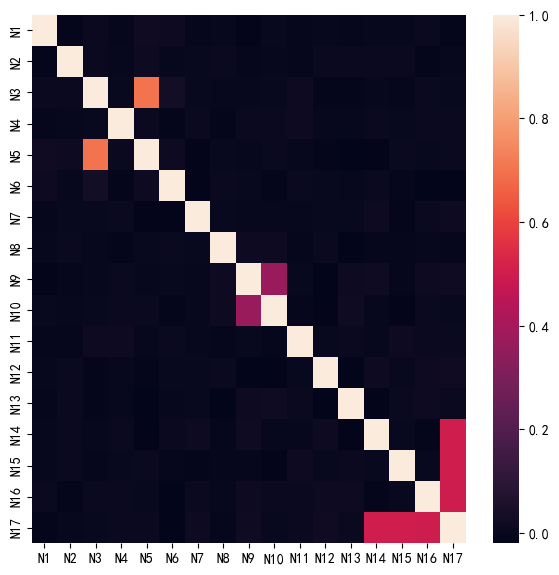

In [18]:
fig , axes = plt.subplots(figsize = (7 , 7) , dpi = 100)
sns.heatmap(df.corr() , ax = axes)

随后开始二分变量和多分类变量的构建

In [19]:
B1 = np.random.choice([0 , 1], size = N , p = [0.7 , 0.3])
B2 = np.random.choice([0 , 1], size = N , p = [0.1 , 0.9])
M1 = np.random.choice([0 , 1 , 2 , 3 , 4 , 5 , 6 , 7] , size = N , p=[0.1 , 0.15 , 0.1 , 0.15 , 0.2 , 0.15 , 0.05 , 0.1])
df['B1'] = B1 ; df['B2'] = B2 ; df['M1'] = M1
df.head(1)

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,N11,N12,N13,N14,N15,N16,N17,B1,B2,M1
0,4.087488,3.374762,2.790009,5.380425,6.49425,3.047669,2.218774,4.960326,2.940928,13.279806,2.951911,4.363929,3.610237,3.221973,3.988676,4.187664,11.205586,0,0,0


可以看到已经完成了数据的构建，下面进行被解释变量的构建

其中白噪声 $ ~ N(\mu = 15 , \sigma^2 = 100)$

In [20]:
construct_df = df.copy()
construct_df['N2^2'] = construct_df['N2'] ** 2
construct_df['N3^2'] = construct_df['N3'] ** 2
construct_df['N12|B1'] = construct_df['N12'] * construct_df['B1']
# 生成模型参数  其中N2 N4 N6 N8 的系数为0
num_beta = np.random.normal(10 , 2 , size = 17) ; num_beta[1] = 0 ; num_beta[3] = 0 ; num_beta[5] = 0 ; num_beta[7] = 0 
left_beta = np.random.normal(4 , 1 , size =6)
beta_list = np.concatenate((num_beta, left_beta), axis=0)  
# 完成被解释变量值的构建
y = construct_df.to_numpy() @ np.array([beta_list]).T + np.random.normal(15 , 10 , size = N)
y = y.T[0]
data_df = pd.concat([pd.Series(y , name = 'Y'), df], axis=1)
data_df.head(3)

,Y,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N11,N12,N13,N14,N15,N16,N17,B1,B2,M1
0,738.733839,4.087488,3.374762,2.790009,5.380425,6.494250,3.047669,2.218774,4.960326,2.940928,...,2.951911,4.363929,3.610237,3.221973,3.988676,4.187664,11.205586,0,0,0
1,884.421053,5.507964,3.622901,4.546705,3.155434,4.655851,4.006453,2.241264,2.522583,4.146088,...,3.911720,2.464947,3.659856,3.819555,5.963679,5.250855,12.969555,0,1,4
2,895.063607,5.959267,5.814854,4.284762,2.123314,6.770825,3.774026,2.724481,1.464847,3.077598,...,2.177023,3.979130,1.091812,2.759855,5.307497,4.288897,12.574025,1,1,0


In [21]:
# 可以看到参数的情况
pd.DataFrame(np.array([beta_list]) , columns = construct_df.columns)

,N1,N2,N3,N4,N5,N6,N7,N8,N9,N10,...,N14,N15,N16,N17,B1,B2,M1,N2^2,N3^2,N12|B1
0,10.371812,0.0,10.816244,0.0,11.93407,0.0,9.487993,0.0,11.244898,8.232927,...,10.391955,7.399361,9.45428,11.004718,5.41894,3.920048,4.072476,3.448718,4.119892,3.462781


可以看到数据的构造已经完成，现在添加缺失值和异常值

In [22]:
rols , cols = (N , 20)
nan_num = 500 ; out_num = 400
# 生成行列索引  
idxs = np.indices((rols, cols))  
# 合并为坐标对
coords = np.array(list(zip(idxs[0].flatten(), idxs[1].flatten())))  
coords = [i.tolist() for i in coords]
np.random.seed(10)
locations = np.random.choice(range(len(coords)) , size = nan_num + out_num , replace = False)
nan_index = locations[:nan_num] ; out_index = locations[nan_num:]
for i in nan_index:
    rols , cols = coords[i][0] , coords[i][1] # 获得这个位置的行索引和列索引
    data_df.iloc[rols , cols+1] =  pd.NA # 使得这个位置的值变为Nan，cols+1是因为要跳过第一列
for i in out_index:
    rols , cols = coords[i][0] , coords[i][1]
    data_df.iloc[rols , cols+1] = 99999 # 强制换成异常值
df = data_df.copy() ; col_names = data_df.columns.to_list()


彻底完成数据的构建 , 现在正式进入程式

# 数据缺失值和异常值自动处理:

首先，拿到一个数据，先预览缺失值情况,并进行相应处理

d:\Github_relate\local_storage\Graduation-Project-Of-Undergraduate\Analyzation_relative\Data_process.py:84: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig , axes = plt.subplots(1 , 2 , figsize = figsize , dpi = dpi)


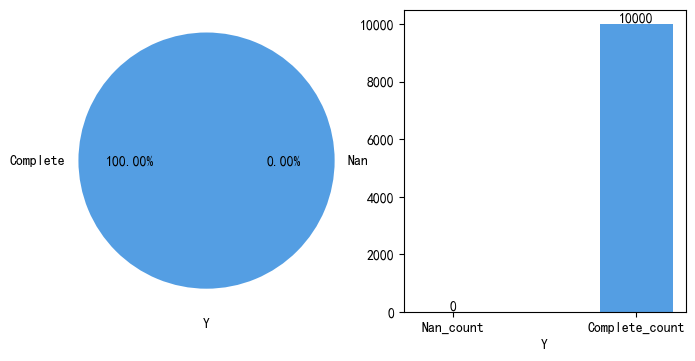

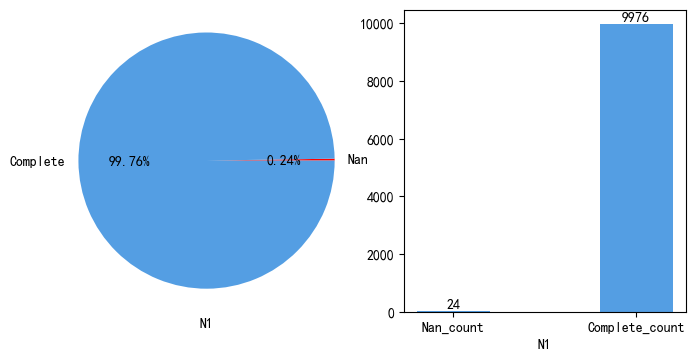

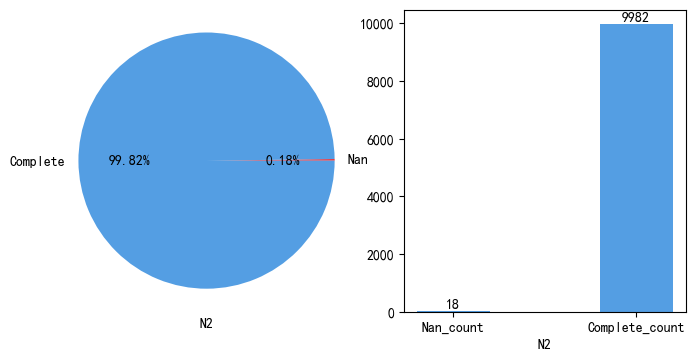

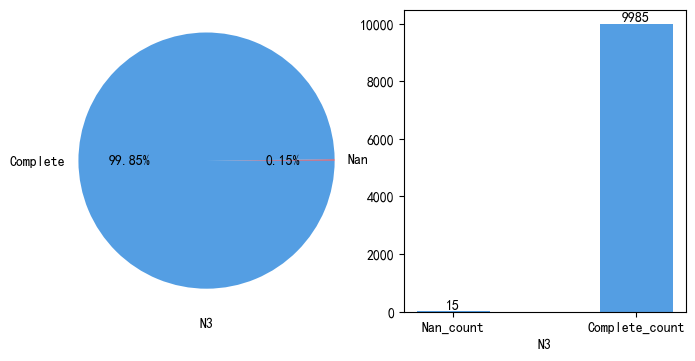

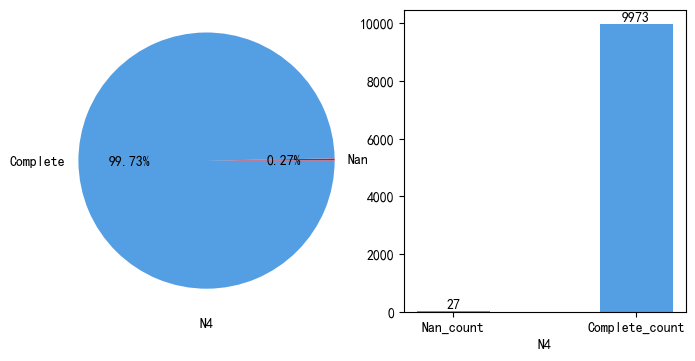

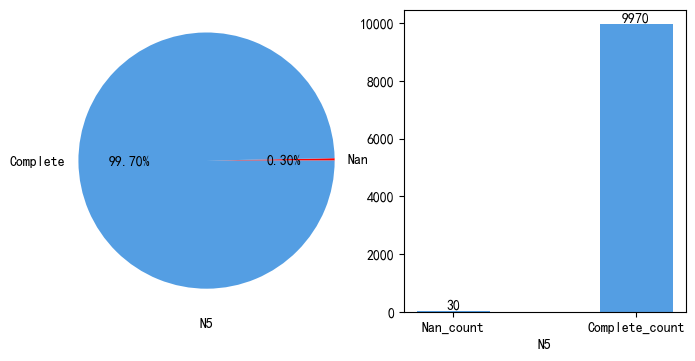

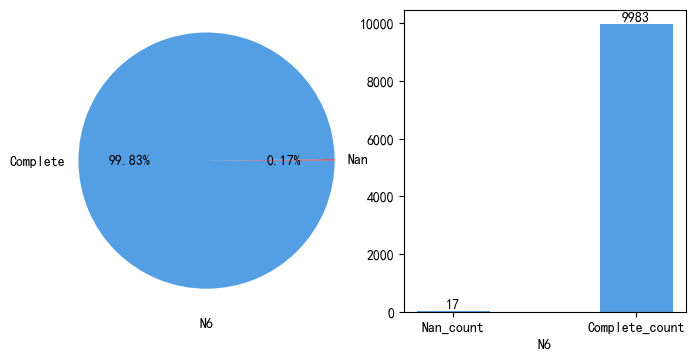

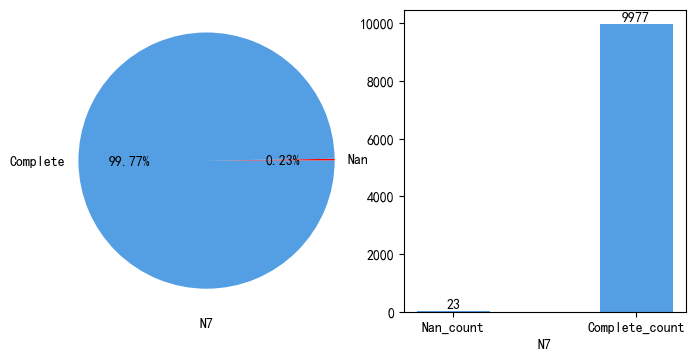

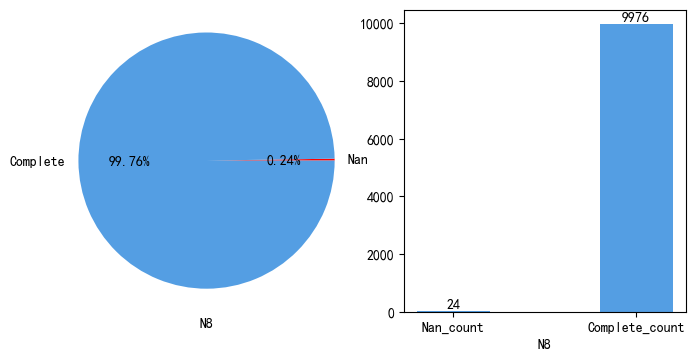

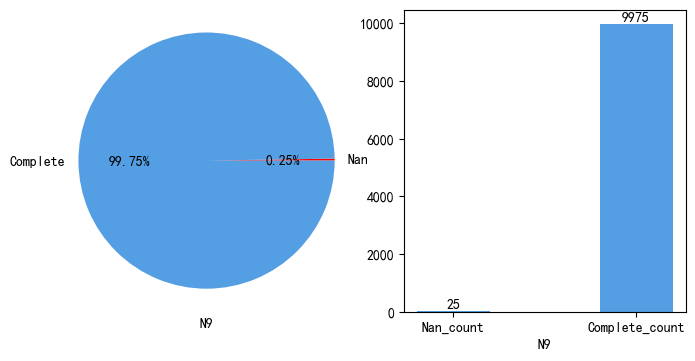

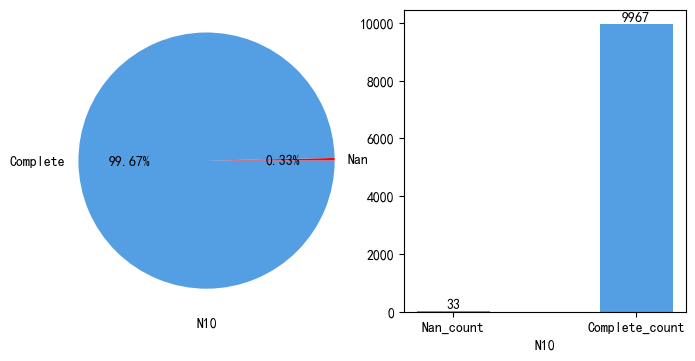

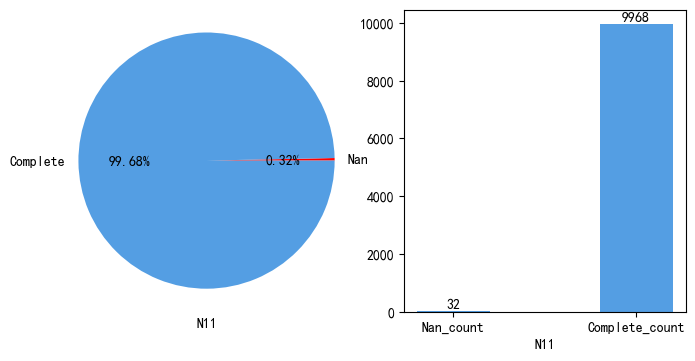

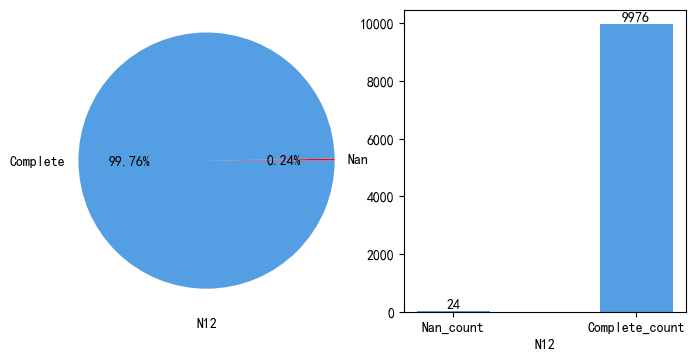

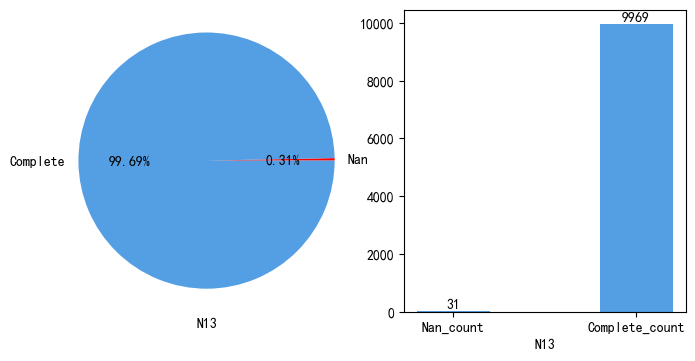

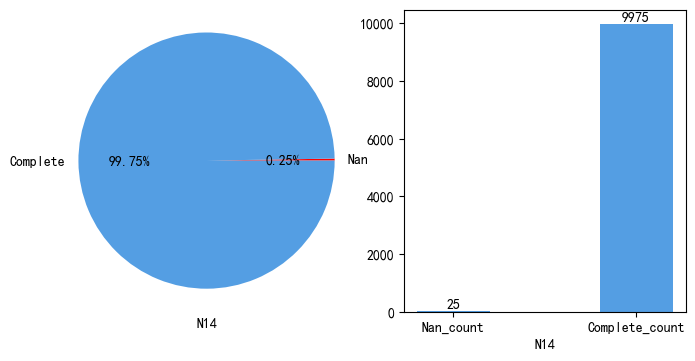

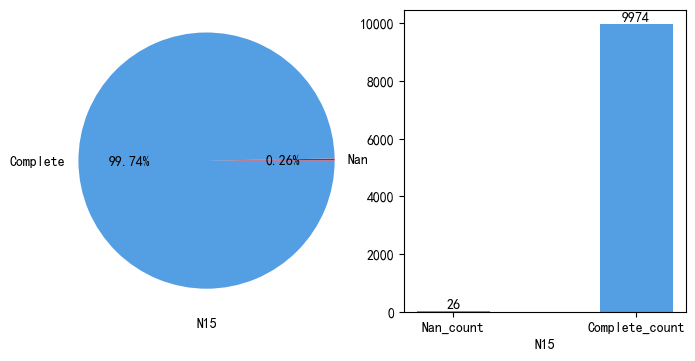

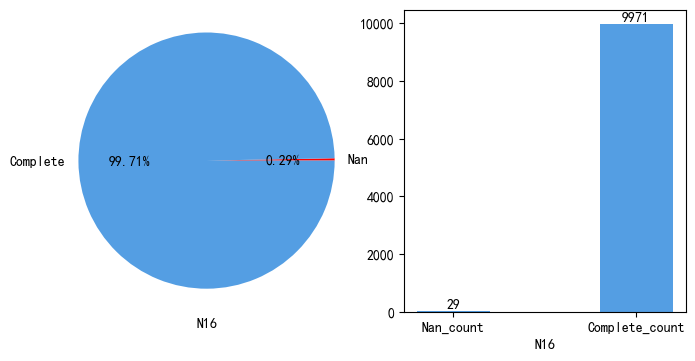

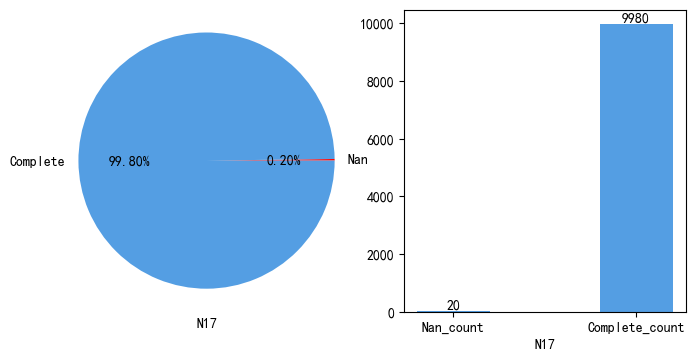

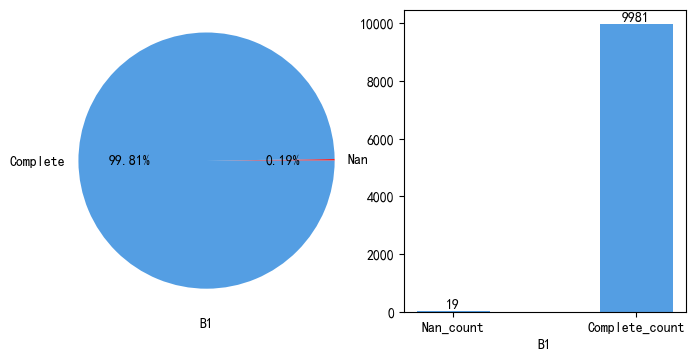

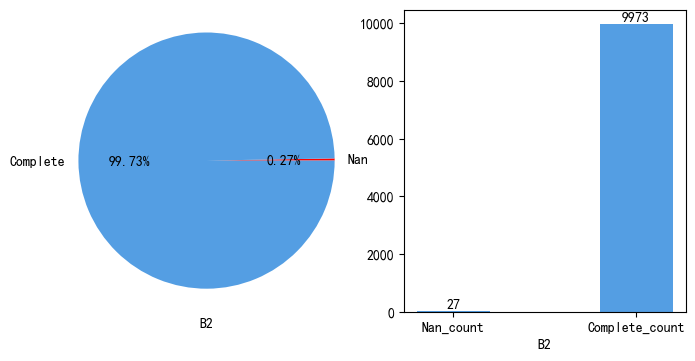

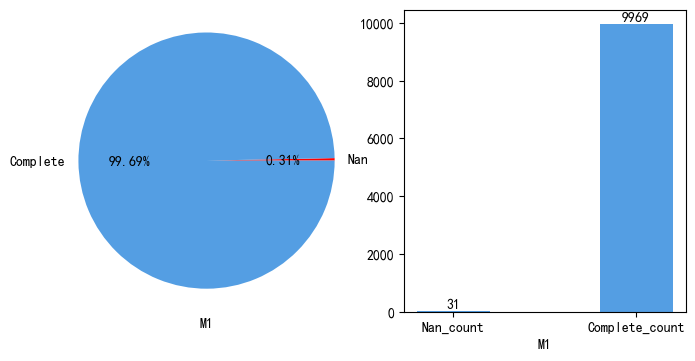

In [23]:
# nan_index , nan_stat = DP.Nan_CountAndPlot(df , filepath = './test/Nan_condition' , plot = False)

# 人为构造数据类型提供指引，如果不构造，则存在异常值的二分类变量会被识别为多分类变量
dataclass = [0 for i in range(17)] + [1 , 1 , 2]
nan_df , df_pro = DP.Nan_process(df , dataclass = [0] + dataclass , filepath = './test/construct_data/Nan_condition')

处理完缺失值后，进行解释变量异常值甄别和处理

In [24]:
num_out_index , bin_out_index , df_outpro = DP.Outlier_TreatAndPlot(df_pro.iloc[: , 1:] , dataclass = dataclass , filepath = './test/construct_data/Outlier_condition' , contamination=0.06)

In [25]:
df_pro.loc[num_out_index , :]

,Y,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N11,N12,N13,N14,N15,N16,N17,B1,B2,M1
3,806.476329,3.773965,99999.000000,3.972178,4.328735,4.750478,3.589762,2.742002,2.563090,2.555568,...,3.181039,2.536294,3.751311,3.221541,3.415821,4.838770,11.198176,1,1,5
38,693.304286,6.790351,3.844383,3.279122,3.791774,3.438105,2.693481,4.251048,4.730913,3.006227,...,2.082089,2.195986,0.291693,3.694436,1.455783,4.326947,10.673271,0,1,2
40,968.728715,5.403864,4.953086,5.207841,4.149238,5.309055,3.671548,3.937680,3.089931,2.133492,...,4.347794,2.756659,2.351257,4.759830,5.310005,99999.000000,12.020070,0,1,4
49,686.807611,4.953065,3.540841,2.874583,3.006838,1.991341,3.181969,2.777873,3.284885,2.617391,...,2.626513,2.528171,4.155898,3.448196,99999.000000,4.289763,11.071719,0,1,0
71,752.435024,4.879761,99999.000000,3.084823,3.895593,5.251728,4.204338,2.273882,3.934520,2.692690,...,1.540785,2.994572,2.641215,3.183492,2.529045,4.380358,9.570676,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9895,754.308765,3.618795,3.692844,4.062196,4.256937,4.638046,3.927202,99999.000000,3.024374,2.395825,...,4.028020,1.947623,3.590580,2.969043,4.579502,4.006188,11.314956,1,1,4
9952,901.263875,3.662675,5.658234,4.318374,3.655158,5.276394,1.771478,3.132803,3.017472,3.380898,...,2.852216,1.933099,4.309483,4.443045,99999.000000,3.494875,13.490822,0,0,1
9971,819.976050,4.513026,4.806580,5.121713,99999.000000,3.818147,4.929608,3.004458,1.881132,3.730298,...,1.908519,3.063769,3.197528,5.320408,4.079121,0.950868,9.014567,1,1,1
9977,870.619467,4.886307,5.008614,4.703988,4.152480,5.760283,3.490859,2.567793,3.018770,3.400244,...,2.660336,2.583975,3.638119,99999.000000,4.858431,3.252149,10.509845,0,1,0


In [26]:
df_pro.loc[bin_out_index , :]

,Y,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N11,N12,N13,N14,N15,N16,N17,B1,B2,M1
1537,953.219391,4.748298,5.690582,4.883965,4.647709,6.778626,3.713227,3.023877,3.116845,3.640211,...,4.738489,2.409397,3.060679,4.915406,4.519511,2.957458,10.466233,0,99999,4
7169,843.579105,6.532643,5.650710,2.611675,4.690374,3.804384,3.756086,3.330460,2.783327,3.607527,...,3.592021,3.750776,3.008105,3.830364,5.004594,3.611750,13.174363,0,99999,6
7045,909.068966,5.793125,5.224696,3.659805,4.801163,5.427845,4.469056,4.151729,2.899435,3.259754,...,2.959200,3.937813,3.269716,4.453937,5.233196,3.110299,13.109418,0,99999,7
8581,810.442242,6.162940,5.968868,3.136638,3.353664,1.011818,2.794436,2.107676,2.611286,2.730989,...,4.428444,2.844913,2.371855,5.433915,3.047825,3.829096,11.935143,1,99999,0
7432,891.937413,3.131094,6.073098,4.263547,4.330704,5.371262,2.806240,1.930416,4.200711,3.012049,...,3.892810,1.791135,3.053369,6.203947,2.690843,4.959072,14.103700,0,99999,0
3086,702.100987,6.059573,4.890101,1.770069,3.937723,2.796444,3.710833,2.507781,3.238852,3.081879,...,2.820593,3.715750,3.548411,4.172986,2.864570,2.739913,11.032518,1,99999,0
1045,1012.132912,5.449433,4.899946,6.212704,4.545634,6.471917,3.580407,3.353580,2.851131,2.985126,...,2.928316,3.924403,2.706445,3.249489,3.827608,5.268889,11.641200,1,99999,6
4891,860.214397,5.046308,4.805766,5.403495,5.392298,6.807721,2.122074,3.393481,3.759856,2.318658,...,2.350321,3.528411,2.425531,1.448850,3.761425,3.278962,8.406876,0,99999,5
2334,818.854155,5.746915,5.034442,3.779914,5.246572,5.144286,3.267289,2.916452,3.128878,3.499093,...,3.133128,1.988203,3.887213,4.290652,2.010953,4.177235,10.502668,0,99999,2
7455,694.944598,4.940992,4.044009,3.351821,3.132814,2.006887,3.204154,3.500612,1.908424,1.725290,...,2.319451,2.296433,2.415976,4.601944,2.177187,3.334424,11.683967,0,99999,3


可以看到程序成功的挑出了异常值并且完成了修正 , 并且从下表可以看到异常值所在行已经被删除

In [27]:
df_outpro

,N1,N17,N16,N15,N14,N13,N12,N11,N10,N8,N7,N6,N5,N4,N3,N2,N9,B2,B1,M1
0,4.087488,11.205586,4.187664,3.988676,3.221973,3.610237,4.363929,2.951911,13.279806,4.960326,2.218774,3.047669,6.494250,5.380425,2.790009,3.374762,2.940928,0,0,0
1,5.507964,12.969555,5.250855,5.963679,3.819555,3.659856,2.464947,3.911720,13.883829,2.522583,2.241264,4.006453,4.655851,3.155434,4.546705,3.622901,4.146088,1,0,4
2,5.959267,12.574025,4.288897,5.307497,2.759855,1.091812,3.979130,2.177023,11.255986,1.464847,2.724481,3.774026,6.770825,2.123314,4.284762,5.814854,3.077598,1,1,0
4,4.853282,13.891023,3.821518,4.991853,4.653684,3.595179,3.790511,2.696277,11.509997,2.808149,2.418760,1.885021,4.292098,2.527007,4.439624,6.090629,3.568572,1,0,7
5,3.783990,11.965253,5.080891,3.192476,3.420723,3.910615,2.838474,2.664190,11.054416,3.168376,2.440245,2.897655,5.111558,2.749069,3.310927,5.115338,2.912952,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,5.172716,12.029670,3.147139,5.533749,5.009611,3.277977,2.555374,2.472918,13.344055,1.642926,2.101407,3.627254,4.846705,3.944076,4.654473,4.765581,2.057638,1,0,2
9995,5.602527,11.209010,1.980633,5.150294,2.937895,4.302728,2.647128,2.552688,13.579262,3.248325,3.611521,2.819208,5.168569,4.741741,5.684454,3.624597,4.460249,1,0,5
9996,5.082607,13.781552,2.613621,6.581181,4.585839,2.415779,1.398749,4.434519,15.962962,3.445568,3.089090,2.372292,4.575040,5.027645,3.627278,4.188246,3.297865,1,1,2
9998,6.149399,12.471009,4.894045,4.102382,3.496764,3.278014,1.609811,2.442544,12.566049,4.076451,3.119515,2.907086,3.903266,4.452216,4.401461,3.164691,3.810225,1,0,3


# 处理完缺失值和异常值后就可以进行数据的预览了:

In [28]:
# 构造完整的去除完缺失值和异常值的数据框
new_df = pd.concat([df_pro.iloc[df_outpro.index , 0] , df_outpro[col_names[1:]]] , axis = 1)
new_df

,Y,N1,N2,N3,N4,N5,N6,N7,N8,N9,...,N11,N12,N13,N14,N15,N16,N17,B1,B2,M1
0,738.733839,4.087488,3.374762,2.790009,5.380425,6.494250,3.047669,2.218774,4.960326,2.940928,...,2.951911,4.363929,3.610237,3.221973,3.988676,4.187664,11.205586,0,0,0
1,884.421053,5.507964,3.622901,4.546705,3.155434,4.655851,4.006453,2.241264,2.522583,4.146088,...,3.911720,2.464947,3.659856,3.819555,5.963679,5.250855,12.969555,0,1,4
2,895.063607,5.959267,5.814854,4.284762,2.123314,6.770825,3.774026,2.724481,1.464847,3.077598,...,2.177023,3.979130,1.091812,2.759855,5.307497,4.288897,12.574025,1,1,0
4,941.765184,4.853282,6.090629,4.439624,2.527007,4.292098,1.885021,2.418760,2.808149,3.568572,...,2.696277,3.790511,3.595179,4.653684,4.991853,3.821518,13.891023,0,1,7
5,806.489478,3.783990,5.115338,3.310927,2.749069,5.111558,2.897655,2.440245,3.168376,2.912952,...,2.664190,2.838474,3.910615,3.420723,3.192476,5.080891,11.965253,1,1,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9994,847.635850,5.172716,4.765581,4.654473,3.944076,4.846705,3.627254,2.101407,1.642926,2.057638,...,2.472918,2.555374,3.277977,5.009611,5.533749,3.147139,12.029670,0,1,2
9995,901.276449,5.602527,3.624597,5.684454,4.741741,5.168569,2.819208,3.611521,3.248325,4.460249,...,2.552688,2.647128,4.302728,2.937895,5.150294,1.980633,11.209010,0,1,5
9996,846.443734,5.082607,4.188246,3.627278,5.027645,4.575040,2.372292,3.089090,3.445568,3.297865,...,4.434519,1.398749,2.415779,4.585839,6.581181,2.613621,13.781552,1,1,2
9998,800.729224,6.149399,3.164691,4.401461,4.452216,3.903266,2.907086,3.119515,4.076451,3.810225,...,2.442544,1.609811,3.278014,3.496764,4.102382,4.894045,12.471009,0,1,3


d:\Github_relate\local_storage\Graduation-Project-Of-Undergraduate\Analyzation_relative\Descriptive_statistics.py:651: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig , axes = plt.subplots(3 , 2 , figsize = figsize , dpi = dpi)


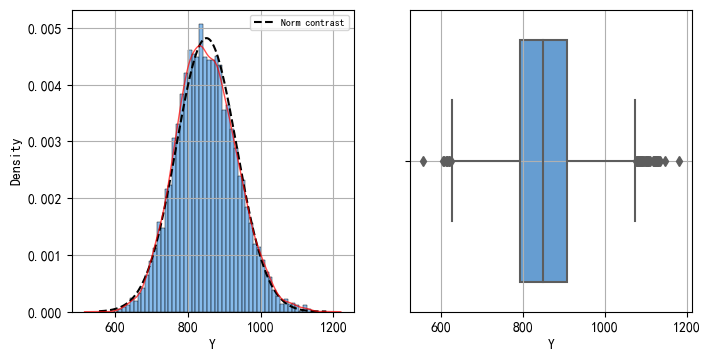

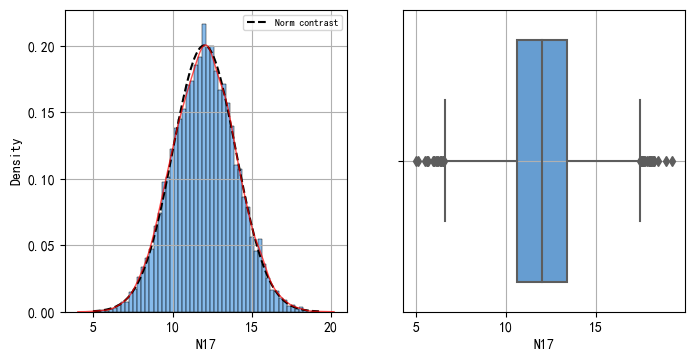

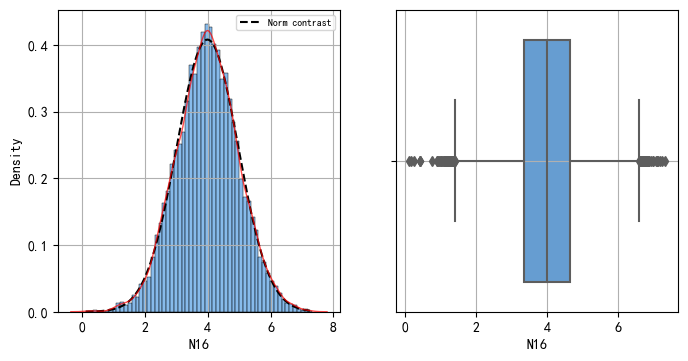

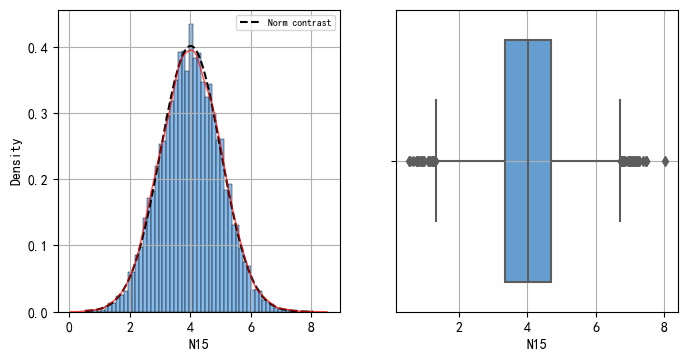

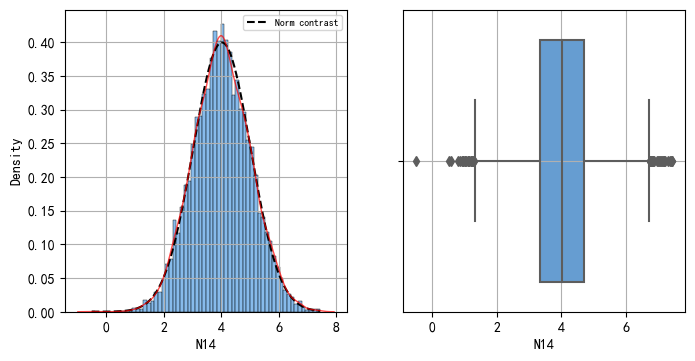

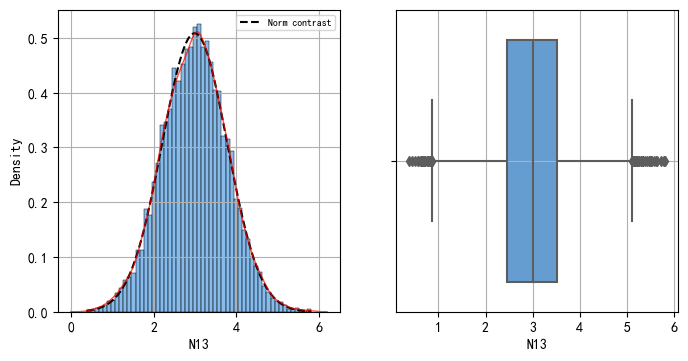

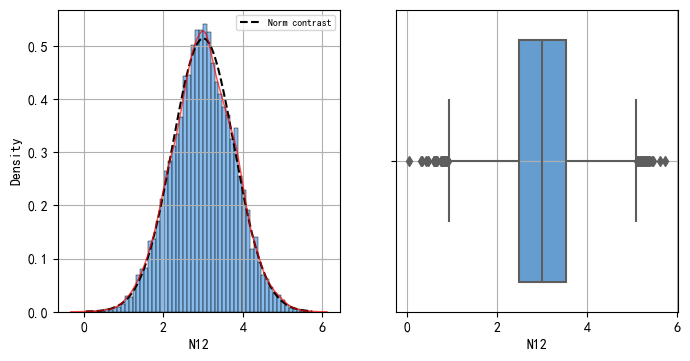

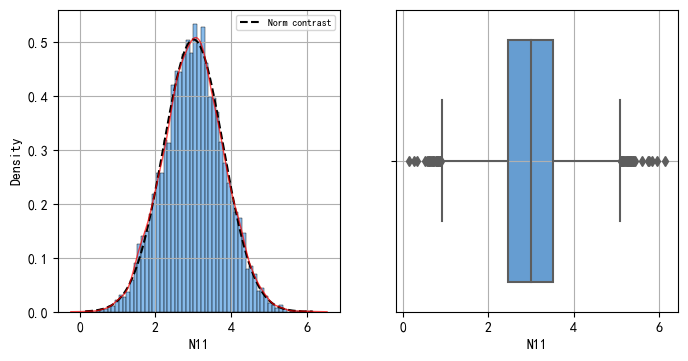

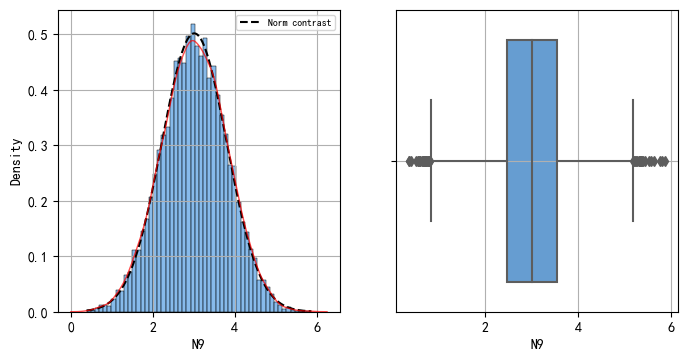

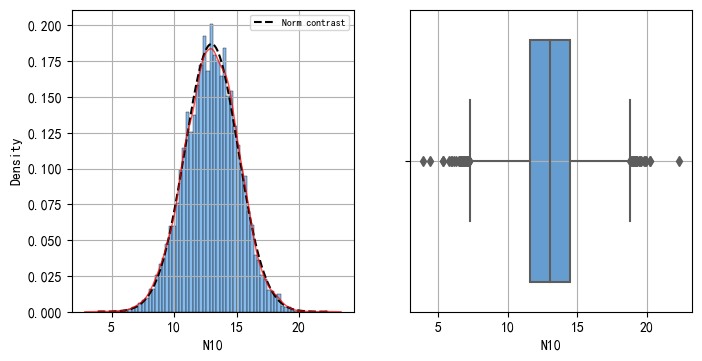

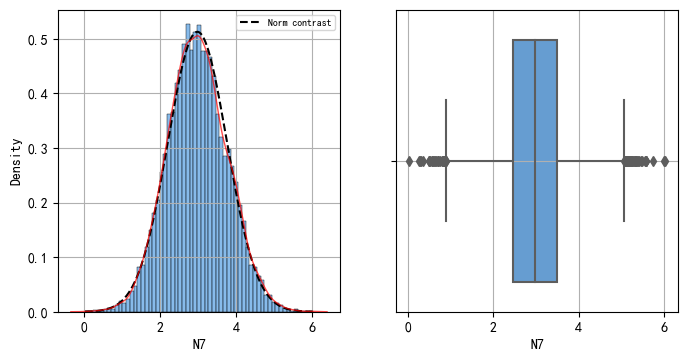

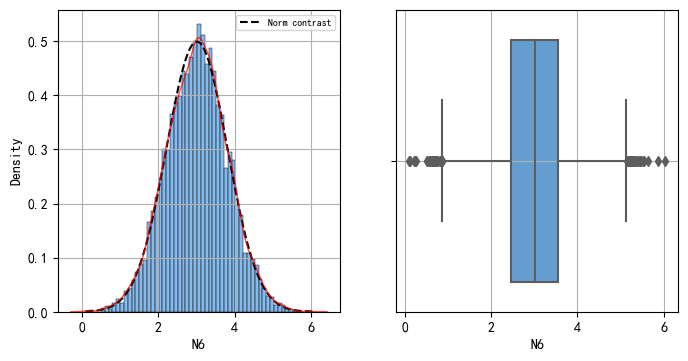

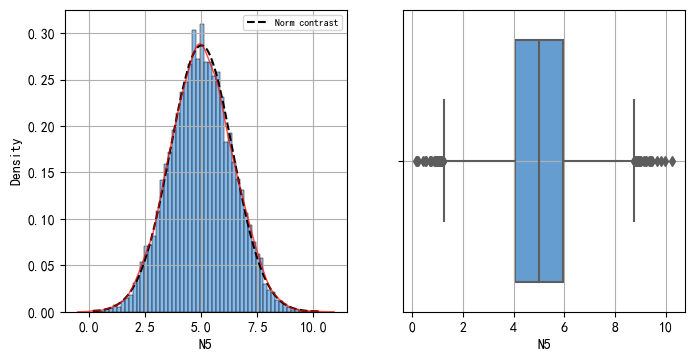

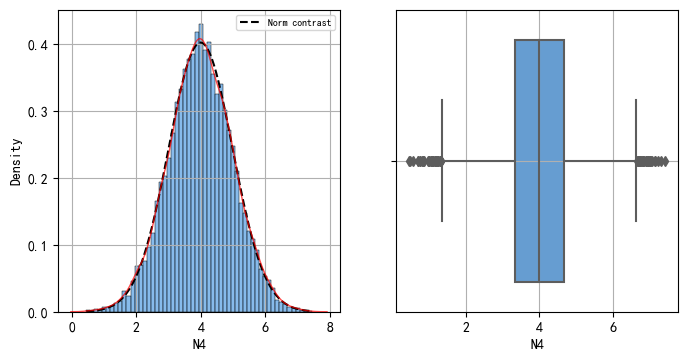

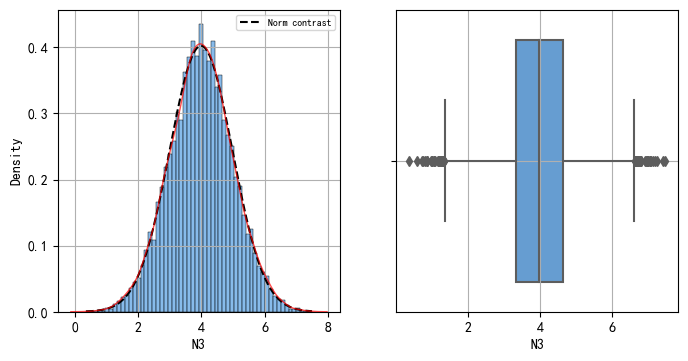

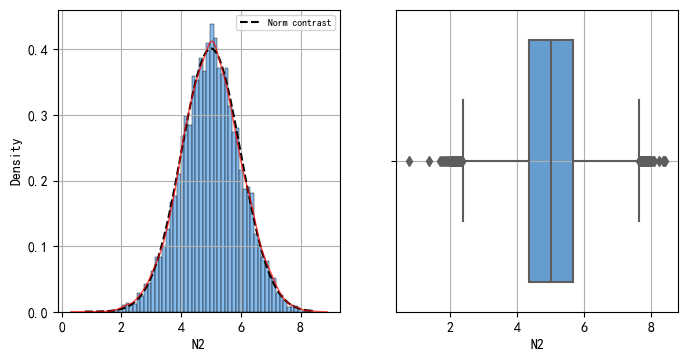

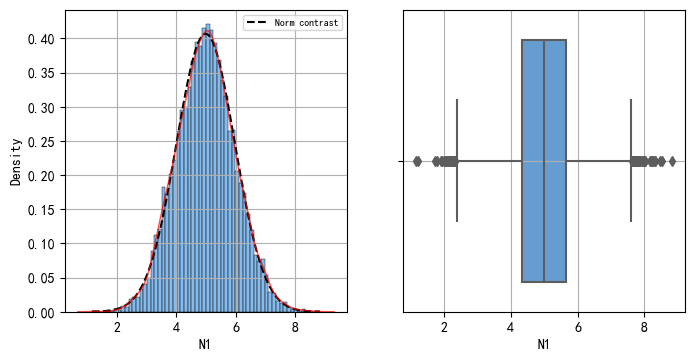

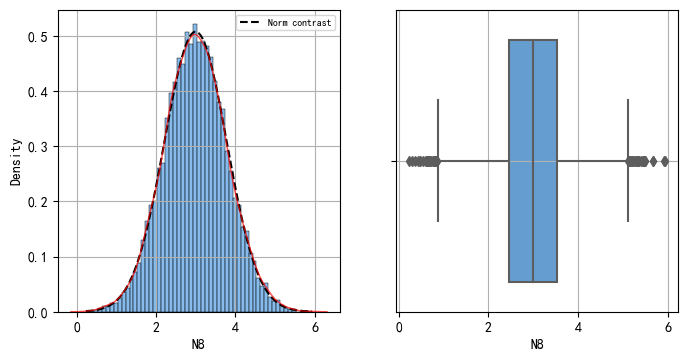

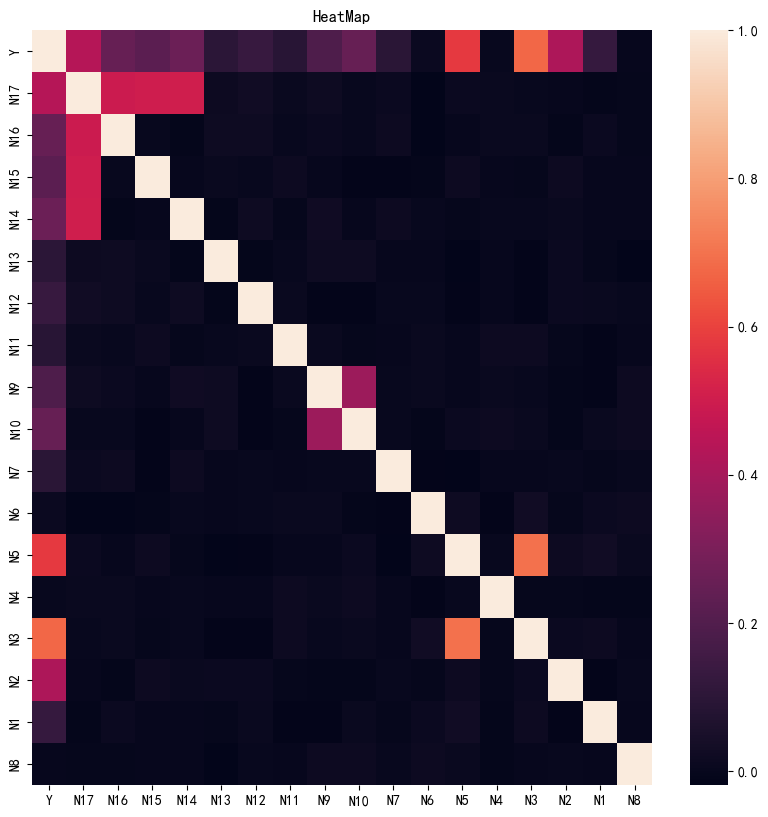

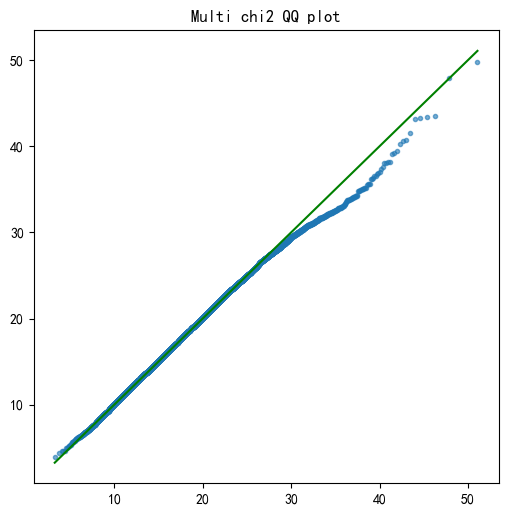

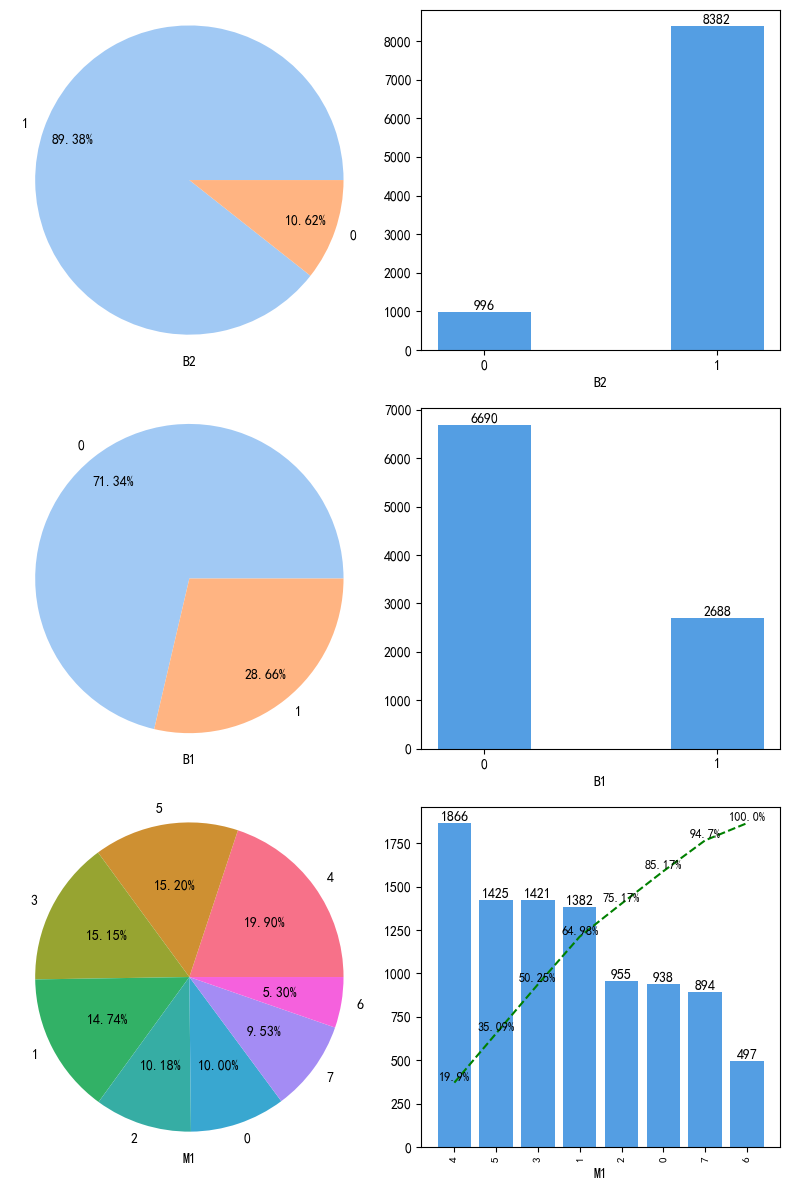

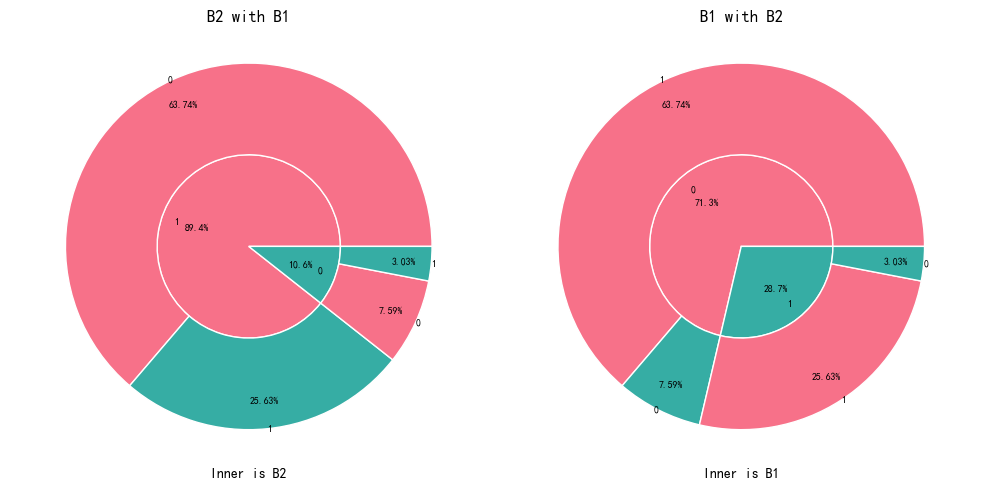

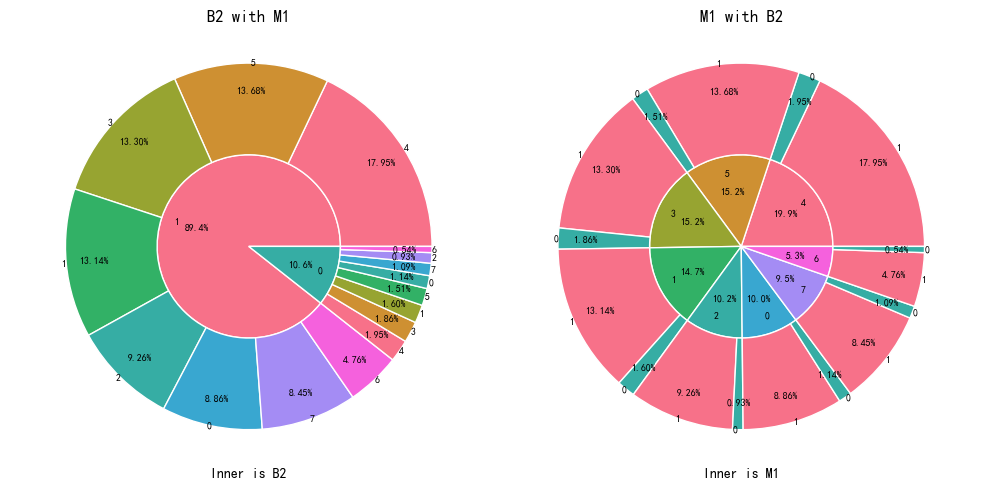

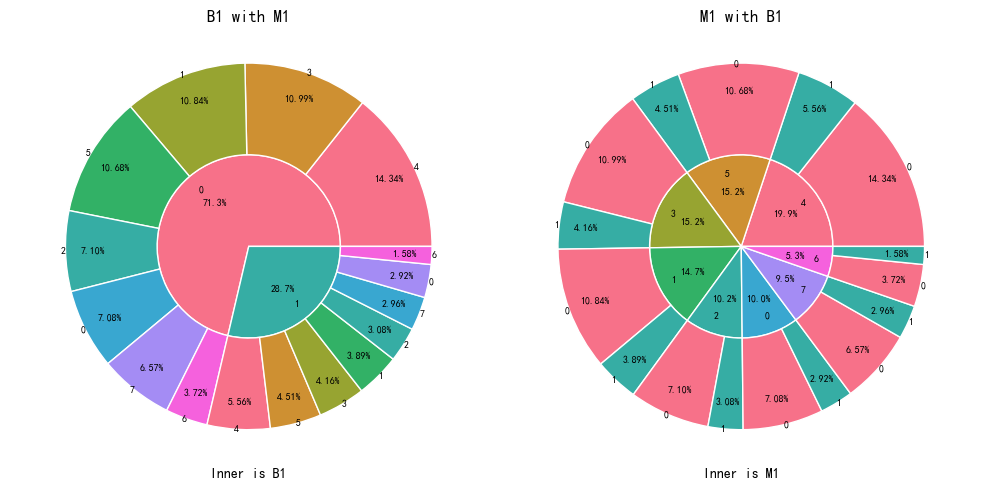

In [29]:
DS.Auto_plt(new_df , dataclass = [0] + dataclass , filepath = './test/construct_data/descriptive_result')

可以看到，想要了解的数据都得到了相对完备的了解。接下来可以进行模型的相应研究了

In [30]:
# 先把数据输出出去
new_df.to_csv('./data/test/display.csv')

# 进行描述性统计之后可以针对模型进行相应的探究了

由于我引入了多线程进行并行计算，所以需要在终端中进行如下代码的运行。（因为Jupyter nootbook的线程间通讯损耗过大）

```python
new_df = pd.read_csv('./data/test/display.csv' , index_col = 0)
mode , Xlist , args_list , result_list = Automatic_reg(new_df , dataclass = None ,target_col = None ,  mode = None , filepath = './test/construct_data')
```

所以整体来看 , 只需要4行代码就可以初步完成对一个数据的清洗和预览。

接下来我将演示程式对于真实数据的泛用性。

```python
nan_df , df_pro = DP.Nan_process(df , dataclass = [0] + dataclass , filepath = './test/construct_data/Nan_condition')

num_out_index , bin_out_index , df_outpro = DP.Outlier_TreatAndPlot(df_pro.iloc[: , 1:] , dataclass = dataclass , filepath = './test/construct_data/Outlier_condition' , contamination=0.06)

DS.Auto_plt(new_df , dataclass = [0] + dataclass , filepath = './test/construct_data/descriptive_result')

mode , Xlist , args_list , result_list = Automatic_reg(new_df , dataclass = None ,target_col = None ,  mode = None , filepath = './test/construct_data')
```